# **CIFAR10 Multiclass classification using VGG16 Neural Network**

# **Setup environment**

In [1]:
from pathlib import Path
import sys

if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    base_folder = Path('/content/drive/MyDrive/Pooja_HP_Singh_Projects/DL')
    data_folder = Path('/content')

    !pip install pytorch-lightning==2.0.9 -qq

    !pip install torchmetrics -U -qq
    !pip install fastdownload -U -qq
    !pip install fastai -U -qq
    !pip install wandb -U -qq

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.7/727.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00


In [2]:
custom_function_folder = base_folder/'custom_functions'
sys.path.append(str(custom_function_folder))
model_folder = base_folder/'HW7_CIFAR_VGG/Models'
model_folder.mkdir(parents=True, exist_ok=True)
project_folder = base_folder/'HW7_CIFAR_VGG/CIFAR_Project/'
sys.path.append(str(project_folder))


In [3]:
# import Libraries
import yaml
import torch
import torch.nn as nn
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning import seed_everything
from pytorch_lightning.tuner import Tuner
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger, WandbLogger
import wandb
import gc

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torchvision.models as models
from multiclass_lightning_module_v0 import MultiClassLightningModule
from shared_utils import  plot_losses_acc

# **Task 1: Data Preparation and Augmentation for CIFAR-10**

**Lightning DataModule for the CIFAR dataset**

In [4]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
import random
from collections import defaultdict
import pytorch_lightning as pl

class TransformedSubset(Dataset):
    """
    A Dataset wrapper that applies a transform to a subset of a dataset.

    Attributes:
    subset (Dataset): The subset of data to which the transform will be applied.
    transform (callable, optional): A function/transform to apply to the images.
    """

    def __init__(self, subset, transform=None):
        self.subset = subset  # The original data subset
        self.transform = transform  # The transform function to apply on the data

    def __getitem__(self, index):
        """
        Retrieve and optionally transform the item (image, label) at the given index.

        Parameters:
        index (int): Index of the item to retrieve.

        Returns:
        tuple: Transformed image and label pair.
        """
        # Retrieve original data
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)



class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, data_dir="./CIFAR10", train_transform=None, test_transform=None,
                 batch_size=64, seed=42, fraction_train=0.8, small_subset=False,
                 num_samples=None):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_transform = train_transform
        self.test_transform = test_transform
        self.seed = seed
        self.fraction_train = fraction_train
        self.small_subset = small_subset
        self.num_samples = num_samples

    def split_dataset(self, base_dataset):
        split_a_size = int(self.fraction_train * len(base_dataset))
        split_b_size = len(base_dataset) - split_a_size

        return torch.utils.data.random_split(
            base_dataset,
            [split_a_size, split_b_size],
            generator=torch.Generator().manual_seed(self.seed)
        )

    def prepare_data(self):
        # download
        datasets.CIFAR10(self.data_dir, train=True, download=True)
        datasets.CIFAR10(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        self.testset = datasets.CIFAR10(
            self.data_dir, transform=self.test_transform, train=False
        )
        self.predictset = datasets.CIFAR10(
            self.data_dir, transform=self.test_transform, train=False
        )
        self.train_val_set = datasets.CIFAR10(
            self.data_dir, train=True
        )
        self.trainset, self.validset = self.split_dataset(self.train_val_set)
        self.trainset_transformed = TransformedSubset(self.trainset, self.train_transform)
        self.validset_transformed = TransformedSubset(self.validset, self.test_transform)

        if self.small_subset:
            self.trainset_transformed = get_stratified_subset(self.trainset_transformed,self.num_samples,seed=42)
            self.validset_transformed = get_stratified_subset(self.validset_transformed,self.num_samples,seed=42)



    def train_dataloader(self):
        return DataLoader(
            self.trainset_transformed, batch_size=self.batch_size, shuffle=True, drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(self.validset_transformed, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.testset, batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.predictset, batch_size=self.batch_size, shuffle=False)


def get_stratified_subset(dataset, num_samples, seed=None):
    if seed is not None:
        random.seed(seed)

    # Step 1: Identify label distribution
    label_to_indices = defaultdict(list)
    for idx, (_, label) in enumerate(dataset):
        label_to_indices[label].append(idx)

    # Step 2: Calculate proportions and initialize subset indices list
    proportions = {label: len(indices) / len(dataset) for label, indices in label_to_indices.items()}
    subset_indices = []

    # Step 3: Sample according to proportion
    for label, indices in label_to_indices.items():
        num_samples_for_label = round(proportions[label] * num_samples)
        subset_indices += random.sample(indices, num_samples_for_label)

    # Step 4: Combine samples
    return torch.utils.data.Subset(dataset, subset_indices)


# **Functions for Transformations- (Data Augmentation)**

In [5]:
def get_train_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            # transforms.RandomCrop([resize_width, rand_crop_width]),
            transforms.RandomHorizontalFlip(),
            #transforms.Resize([rand_crop_width, reresize_width]),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )

def get_test_transforms(resize_height, resize_width, normalize_mean, normalize_std):

    return transforms.Compose(
        [
            transforms.Resize((resize_height, resize_width)),
            # transforms.CenterCrop([resize_width, center_crop_width]),
            #transforms.Resize([center_crop_width, reresize_width]),
            transforms.ToTensor(),
            transforms.Normalize(normalize_mean, normalize_std),
        ]
    )

# **Function to load the model**

In [6]:
# Function to load the model
def load_model():

  model = models.vgg16(weights='DEFAULT')
  for param in model.parameters():
    param.requires_grad = False

  # model.classifier[0].requires_grad = True
  # model.classifier[3].requires_grad = True
  model.classifier[6] = torch.nn.Linear(4096,10)
  for param in model.classifier[6].parameters():
    param.requires_grad = True

  return model

# **Function to load DataModule**

In [7]:
def load_datamodule(config, data_folder):
    # Fetch the correct transform function based on config and pass the appropriate arguments
    train_transform = get_train_transforms(**config['train_transform'])
    test_transform = get_test_transforms(**config['test_transform'])
    dm = CIFAR10DataModule(
        data_dir=data_folder,
        train_transform=train_transform,
        test_transform=test_transform,
        **config['data_module']
    )
    return dm

# **Function to load LightningModule**

In [8]:
def load_lightning_module(config, model):
    optimizer_cls = eval(config['optimizer_cls'])
    loss_fn = eval(config['loss_fn'])()  # directly instantiate the loss function
    metric_cls = eval(config['metric_cls'])

    # If scheduler is defined, convert its string to class as well
    if config.get('scheduler_cls'):
        scheduler_cls = eval(config['scheduler_cls'])
        scheduler_options = config['scheduler_options']
        scheduler_params =   config['scheduler_params']
    else:
        scheduler_cls = None

    lightning_module = MultiClassLightningModule(model=model,
                                                 optimizer_cls=optimizer_cls,
                                                 loss_fn=loss_fn,
                                                 metric_cls=metric_cls,
                                                 scheduler_cls=scheduler_cls,
                                                 scheduler_options=scheduler_options,
                                                 scheduler_params=scheduler_params,
                                                 **config['others']
)
    return lightning_module

# **Function to load the Trainer**

In [9]:
def load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=False, checkpointing=True, early_stopping=False):

    lr_monitor = LearningRateMonitor(**cl_config['lr_monitor'])
    callbacks = [lr_monitor]
    if checkpointing:
        model_checkpoint_callback = ModelCheckpoint(dirpath=model_folder/cl_config['log_dir'],
                                                **cl_config['model_checkpoint'])
        callbacks.append(model_checkpoint_callback)

    if early_stopping:
        early_stop_callback = EarlyStopping(**cl_config['early_stopping'] )
        callbacks.append(early_stop_callback)

    if logging:
        # For WandB logger:
        # wandb_logger = WandbLogger(project=cl_config['wandb']['project'], name=cl_config['wandb']['name'], save_dir=model_folder/cl_config['log_dir'])
        # wandb_logger.experiment.config.update({'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})
        # model = load_model() #newly added line
        # wandb_logger.watch(model)

        # For CSV logger:
        csv_logger = CSVLogger(save_dir=model_folder/cl_config['log_dir'], name=cl_config['csv']['name'])
        csv_logger.log_hyperparams(params={'batch_size': batch_size, 'epochs': trainer_config['max_epochs']})

        trainer = pl.Trainer(callbacks=callbacks,
                            logger=[csv_logger],
                            **trainer_config)
    else:
        trainer = pl.Trainer(callbacks=callbacks,
                            **trainer_config
                )
    return trainer

# **Function to load components**

In [10]:
def load_components(data_module_config, lightning_module_config, data_folder, trainer_config,
cl_config, batch_size,logging=False, checkpointing=True, early_stopping=False):

    # Load the model
    model = load_model()

    # Load the data module
    dm = load_datamodule(data_module_config, data_folder)

    # Load the lightning module
    lightning_module = load_lightning_module(lightning_module_config, model)

    # Load the trainer
    trainer = load_trainer(model, trainer_config, cl_config, batch_size, model_folder,  logging=logging,
                           checkpointing=checkpointing, early_stopping=early_stopping)

    return model, dm, lightning_module, trainer

In [11]:
def load_yaml(filepath):
    with open(filepath, 'r') as file:
        return yaml.safe_load(file)

# **Function to Load config files**

In [12]:
# Load configurations from YAML files
def load_all_configs():
    #model_config = load_yaml(project_folder/'model_config.yaml')
    data_module_config = load_yaml(project_folder/'data_module_config.yaml')
    lightning_module_config = load_yaml(project_folder/'lightning_module_config.yaml')
    cl_config = load_yaml(project_folder/'callbacks_loggers_config.yaml')
    trainer_config = load_yaml(project_folder/'trainer_config.yaml')

    return data_module_config, lightning_module_config, cl_config, trainer_config

# **Function to free memory**

In [13]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

# **Run One training and validation batch to check bugs**

In [14]:
# Load components
free_memory()
seed_everything(42)
data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['fast_dev_run']=True
model, dm, lightning_module, trainer = load_components(data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.prepare_data()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 188MB/s]
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.


100%|██████████| 170498071/170498071 [00:02<00:00, 75608481.14it/s]


Extracting /content/cifar-10-python.tar.gz to /content
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
41.0 K    Trainable params
134 M     Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to i

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.16 | 

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1` reached.


Train_Loss: 2.34, Train_Metric: 0.09


# **Find Learning Rate**

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1: Val_Loss: 2.32, Val_Metric: 0.11 | 

Finding best initial lr:   0%|          | 0/30 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=30` reached.
INFO:pytorch_lightning.tuner.lr_finder:Learning rate set to 0.009999999999999997
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_f2edbafe-38d4-4f63-8aed-c81224fe7df8.ckpt


Train_Loss: 3.24, Train_Metric: 0.35


INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_f2edbafe-38d4-4f63-8aed-c81224fe7df8.ckpt


0.009999999999999997


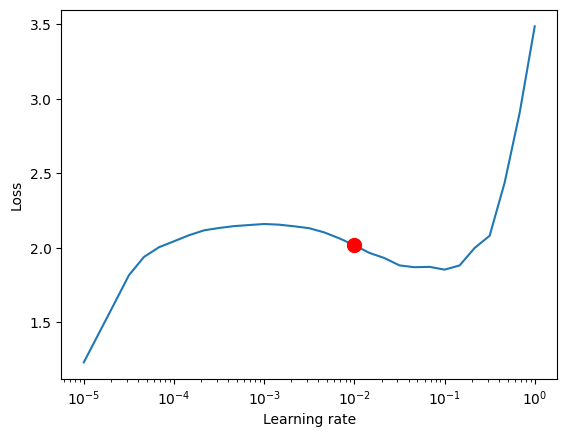

In [ ]:
# Load components
free_memory()
seed_everything(42)
data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()
# override default values
trainer_config['max_epochs']= 25
data_module_config['data_module']['batch_size']=64

model, dm, lightning_module, trainer = load_components(data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
tuner = Tuner(trainer)
lr_finder = tuner.lr_find(lightning_module, datamodule=dm, min_lr=1e-5, max_lr=1, num_training=30, mode='exponential')
fig = lr_finder.plot(suggest=True)
new_lr = lr_finder.suggestion()
print(new_lr)

# **Overfit Small Subset**

In [ ]:
# Load components

free_memory()
seed_everything(42)
data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# override default values
data_module_config['data_module']['batch_size']=64
trainer_config['overfit_batches']=1
lightning_module_config['others']['learning_rate']=0.07
trainer_config['max_epochs']=3
model, dm, lightning_module, trainer = load_components(data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=False, checkpointing=False, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
41.0 K    Trainable params
134 M     Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.32, Val_Metric: 0.11 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:262: UserWarning: You requested to overfit but enabled train dataloader shuffling. We are turning off the train dataloader shuffling for you.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.30, Val_Metric: 0.11 | Train_Loss: 2.32, Train_Metric: 0.09


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 2.27, Val_Metric: 0.12 | Train_Loss: 2.24, Train_Metric: 0.16


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 2.25, Val_Metric: 0.23 | Train_Loss: 2.16, Train_Metric: 0.16


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


# **Task 2 : Fine-Tuning Classifier Layers of VGG16**

In [ ]:
loader = dm.train_dataloader()

mean1 = 0.0
for images, _ in loader:
    # shape of image [64 , 3, 500, 375]
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1) # shape : [64, 3, 500*375]
    mean1 += images.mean(2).sum(0) # shape [3]

mean1 = mean1 / len(loader.dataset)

var1 = 0.0
for images, _ in loader:
    batch_samples = images.size(0) # image shape : [64 , 3, 500, 375]
    images = images.view(batch_samples, images.size(1), -1) # image shape : [64, 3, 500*375]
    # mean shape [3,1]
    var1 += ((images - mean1.unsqueeze(1))**2).sum([0,2]) # variance shape [3]

std1 = torch.sqrt(var1 / (len(loader.dataset)*500*375)) # std = sqrt(var/n) n - total pixels
print(mean1, std1)

tensor([0.0016, 0.0019, 0.0031]) tensor([1.1922, 1.1922, 1.2757])


INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
41.0 K    Trainable params
134 M     Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.15, Val_Metric: 0.27 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 1.76, Val_Metric: 0.59 | Train_Loss: 2.07, Train_Metric: 0.31


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.22, Val_Metric: 0.64 | Train_Loss: 1.47, Train_Metric: 0.57


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.99, Val_Metric: 0.68 | Train_Loss: 1.11, Train_Metric: 0.63


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.90, Val_Metric: 0.69 | Train_Loss: 0.98, Train_Metric: 0.66


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.84, Val_Metric: 0.71 | Train_Loss: 0.93, Train_Metric: 0.67


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.82, Val_Metric: 0.72 | Train_Loss: 0.90, Train_Metric: 0.68


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 0.80, Val_Metric: 0.72 | Train_Loss: 0.87, Train_Metric: 0.68


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 0.80, Val_Metric: 0.72 | Train_Loss: 0.87, Train_Metric: 0.69


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.79, Val_Metric: 0.72 | Train_Loss: 0.85, Train_Metric: 0.69


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.78, Val_Metric: 0.73 | Train_Loss: 0.84, Train_Metric: 0.69


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


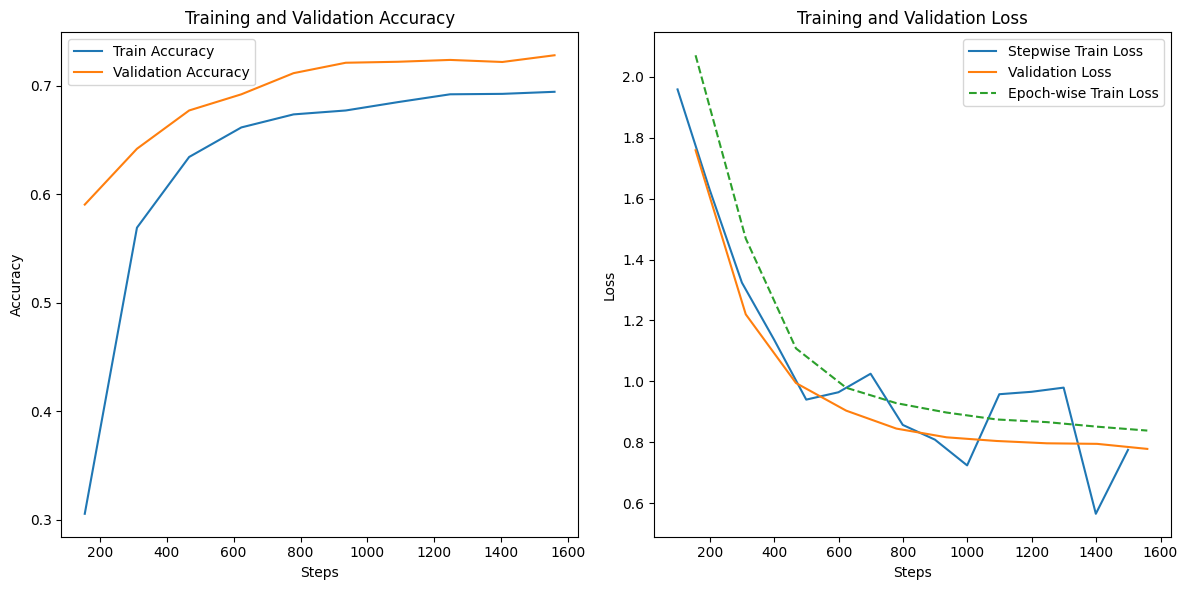

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (

Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.70, Val_Metric: 0.76 | Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.78, Val_Metric: 0.73 | Train Accuracy: 75.57
Validation Accuracy: 72.82


In [ ]:
free_memory()
seed_everything(42)
data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# trainer_config
trainer_config['max_epochs']=10
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=100

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']=0.1
lightning_module_config['others']['learning_rate']=0.0001
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.OneCycleLR'

lightning_module_config['scheduler_params']= {'max_lr':0.001, 'epochs': 10, 'steps_per_epoch':312, 'pct_start':0.3 }
lightning_module_config['scheduler_options']= {'monitor': 'val_metric', 'interval': 'step', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='CIFAR_multiclass_VGG'
cl_config['wandb']['name']='VGG_exp1'

# Data Module
data_module_config['data_module']['batch_size']=64
data_module_config['data_module']['small_subset']=True
data_module_config['data_module']['num_samples']= 10000

model, dm, lightning_module, trainer = load_components(data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")


In [ ]:
ckpt_path = trainer.checkpoint_callback.best_model_path
#best_model1 = lightning_module.load_from_checkpoint(ckpt_path)  # Load your trained model

In [ ]:
test_acc = trainer.test(dataloaders=dm.test_dataloader(),
                        ckpt_path=ckpt_path,
                        verbose=True)

print(f"Test Accuracy: {test_acc[0]['test_metric']*100:0.2f}")

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_metric        │    0.7268000245094299     │
└───────────────────────────┴───────────────────────────┘

Test Accuracy: 72.68


# **Task 3: Fine-Tuning from the Last CNN Block in VGG16**

In [ ]:
# Function to load the model
def load_model():
  # Load pre-trained VGG16
  vgg16 = models.vgg16(pretrained=True)

  # Identify the index of the features[24] layer
  unfreeze_from_layer = 24

  # Unfreeze layers starting from the specified layer
  for param in vgg16.features[unfreeze_from_layer:].parameters():
      param.requires_grad = True

  # Modify the classifier to match the number of classes in your task
  vgg16.classifier[6] = nn.Linear(4096, 10)  # Replace num_classes with your actual number of classes



  return vgg16

INFO:lightning_fabric.utilities.seed:Global seed set to 42
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: Val_Loss: 2.15, Val_Metric: 0.27 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 1.12, Val_Metric: 0.63 | Train_Loss: 1.17, Train_Metric: 0.58


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.47, Val_Metric: 0.49 | Train_Loss: 1.15, Train_Metric: 0.60


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 1.24, Val_Metric: 0.57 | Train_Loss: 1.30, Train_Metric: 0.56


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 1.08, Val_Metric: 0.62 | Train_Loss: 1.15, Train_Metric: 0.60


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.81, Val_Metric: 0.72 | Train_Loss: 0.93, Train_Metric: 0.68


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.74, Val_Metric: 0.75 | Train_Loss: 0.74, Train_Metric: 0.74


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 0.65, Val_Metric: 0.78 | Train_Loss: 0.59, Train_Metric: 0.80


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 0.59, Val_Metric: 0.80 | Train_Loss: 0.38, Train_Metric: 0.87


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.59, Val_Metric: 0.82 | Train_Loss: 0.22, Train_Metric: 0.93


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.59, Val_Metric: 0.82 | Train_Loss: 0.14, Train_Metric: 0.96


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


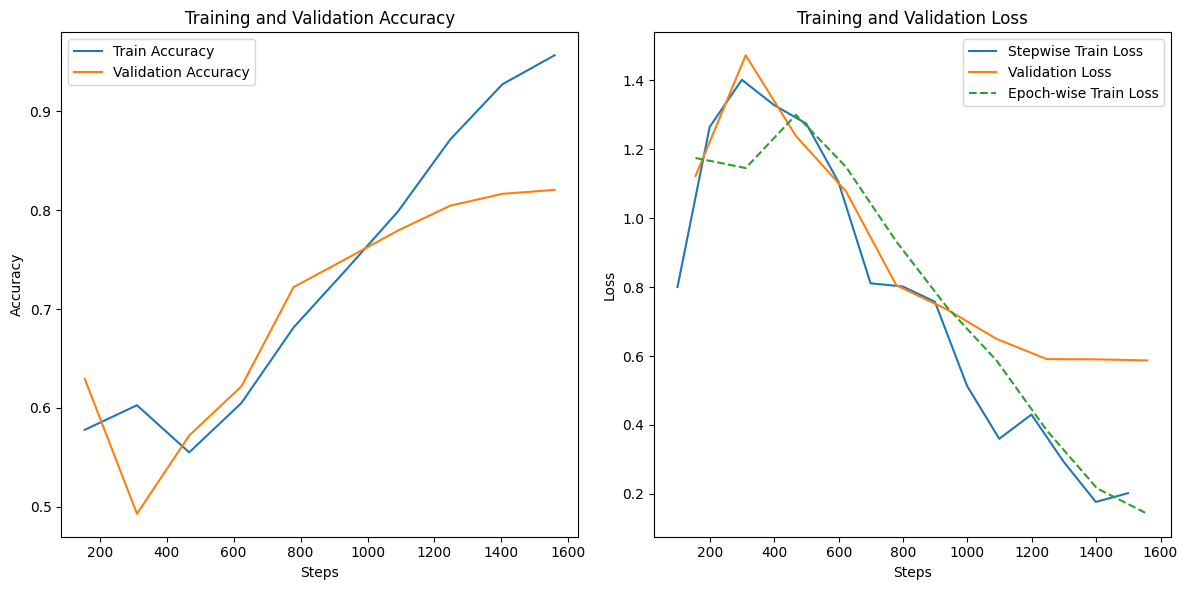

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (

Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.11, Val_Metric: 0.97 | Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.59, Val_Metric: 0.82 | Train Accuracy: 96.76
Validation Accuracy: 82.05


In [ ]:
free_memory()
seed_everything(42)
data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# trainer_config
trainer_config['max_epochs']=10
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=100

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']=0.1
lightning_module_config['others']['learning_rate']=0.0001
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.OneCycleLR'
lightning_module_config['scheduler_params']= {'max_lr':0.001, 'epochs': 10, 'steps_per_epoch':156, 'pct_start':0.3 }
lightning_module_config['scheduler_options']= {'monitor': 'val_metric', 'interval': 'step', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='CIFAR_multiclass_VGG'
cl_config['wandb']['name']='VGG_exp2'

# Data Module
data_module_config['data_module']['batch_size']=64
data_module_config['data_module']['small_subset']=True
data_module_config['data_module']['num_samples']=10000

model, dm, lightning_module, trainer = load_components(data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
#wandb.finish()


In [ ]:
ckpt_path = trainer.checkpoint_callback.best_model_path

In [ ]:
test_acc = trainer.test(dataloaders=dm.test_dataloader(),
                        ckpt_path=ckpt_path,
                        verbose=True)

print(f"Test Accuracy: {test_acc[0]['test_metric']*100:0.2f}")

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_metric        │     0.817799985408783     │
└───────────────────────────┴───────────────────────────┘

Test Accuracy: 81.78


# **Task 4: Fine-Tuning from the Last Two CNN Blocks in VGG16**

In [ ]:
# Function to load the model
def load_model():
  # Load pre-trained VGG16
  vgg16 = models.vgg16(pretrained=True)

  # Identify the index of the features[24] layer
  unfreeze_from_layer = 17

  # Unfreeze layers starting from the specified layer
  for param in vgg16.features[unfreeze_from_layer:].parameters():
      param.requires_grad = True

  # Modify the classifier to match the number of classes in your task
  vgg16.classifier[6] = nn.Linear(4096, 10)  # Replace num_classes with your actual number of classes



  return vgg16

INFO:lightning_fabric.utilities.seed:Global seed set to 42
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.15, Val_Metric: 0.27 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 1.10, Val_Metric: 0.63 | Train_Loss: 1.17, Train_Metric: 0.58


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.33, Val_Metric: 0.54 | Train_Loss: 1.15, Train_Metric: 0.61


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 1.23, Val_Metric: 0.59 | Train_Loss: 1.31, Train_Metric: 0.54


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 1.12, Val_Metric: 0.63 | Train_Loss: 1.14, Train_Metric: 0.61


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.91, Val_Metric: 0.68 | Train_Loss: 0.97, Train_Metric: 0.67


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.76, Val_Metric: 0.74 | Train_Loss: 0.81, Train_Metric: 0.73


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 0.65, Val_Metric: 0.78 | Train_Loss: 0.60, Train_Metric: 0.80


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 0.59, Val_Metric: 0.80 | Train_Loss: 0.39, Train_Metric: 0.87


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.59, Val_Metric: 0.82 | Train_Loss: 0.24, Train_Metric: 0.92


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.58, Val_Metric: 0.83 | Train_Loss: 0.16, Train_Metric: 0.95


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


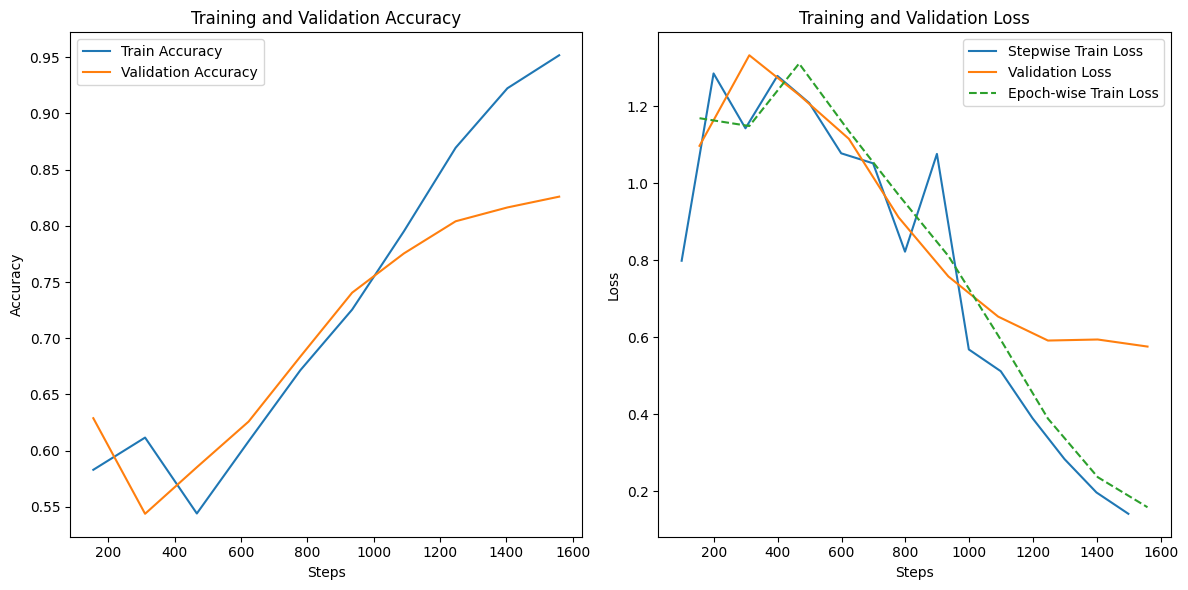

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560-v1.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argum

Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.12, Val_Metric: 0.97 | Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560-v1.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.58, Val_Metric: 0.83 | Train Accuracy: 96.78
Validation Accuracy: 82.59


In [ ]:
free_memory()
seed_everything(42)
data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# trainer_config
trainer_config['max_epochs']=10
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=100

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']=0.1
lightning_module_config['others']['learning_rate']=0.0001
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.OneCycleLR'
lightning_module_config['scheduler_params']= {'max_lr':0.001, 'epochs': 10, 'steps_per_epoch':156, 'pct_start':0.3 }
lightning_module_config['scheduler_options']= {'monitor': 'val_metric', 'interval': 'step', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='CIFAR_multiclass_VGG'
cl_config['wandb']['name']='VGG_exp2'

# Data Module
data_module_config['data_module']['batch_size']=64
data_module_config['data_module']['small_subset']=True
data_module_config['data_module']['num_samples']=10000

model, dm, lightning_module, trainer = load_components(data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
#wandb.finish()


In [ ]:
ckpt_path = trainer.checkpoint_callback.best_model_path

In [ ]:
test_acc = trainer.test(dataloaders=dm.test_dataloader(),
                        ckpt_path=ckpt_path,
                        verbose=True)

print(f"Test Accuracy: {test_acc[0]['test_metric']*100:0.2f}")

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560-v1.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560-v1.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_metric        │    0.8167999982833862     │
└───────────────────────────┴───────────────────────────┘

Test Accuracy: 81.68


# **Task 5: Dynamic Learning Rate Adjustment**

In [ ]:
import pytorch_lightning as pl
import torch

class MultiClassLightningModule(pl.LightningModule):
    def __init__(self, model, optimizer_cls, loss_fn, metric_cls, num_classes, learning_rate, optimizer_params=None,
                 scheduler_cls=None, scheduler_params=None, scheduler_options=None, log_every_n_steps=50,
                 log_test_metrics=True, display_metrics=True, lower_lr_layers=None, higher_lr_layers=None):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model
        self.loss_fn = loss_fn
        self.num_classes = num_classes
        self.train_metric = metric_cls(task="multiclass", num_classes=self.num_classes)
        self.val_metric = metric_cls(task="multiclass", num_classes=self.num_classes)
        self.test_metric = metric_cls(task="multiclass", num_classes=self.num_classes)
        self.log_every_n_steps = log_every_n_steps
        self.log_test_metrics = log_test_metrics
        self.optimizer_cls = optimizer_cls
        self.display_metrics = display_metrics
        self.optimizer_params = optimizer_params if optimizer_params else {}
        self.scheduler_cls = scheduler_cls
        self.scheduler_params = scheduler_params if scheduler_params else {}
        self.scheduler_options = scheduler_options if scheduler_options else {}
        self.lower_lr_layers = lower_lr_layers
        self.higher_lr_layers = higher_lr_layers
        self.save_hyperparameters(ignore=['model', 'loss_fn'])


    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        inputs, labels = batch
        output = self(inputs)
        loss = self.loss_fn(output, labels)
        predicted_labels = torch.argmax(output, dim=1)
        return loss, labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        if batch_idx % self.log_every_n_steps == 0:
            self.log("train_loss_step", loss, on_step=True, on_epoch=False)
        self.train_metric(predicted_labels, labels)
        self.log("train_loss_epoch", loss, on_step=False, on_epoch=True, sync_dist=True)
        self.log("train_metric", self.train_metric, prog_bar=True, on_step=False, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        if self.display_metrics:
            metrics = self.trainer.callback_metrics
            print(f"Train_Loss: {metrics['train_loss_epoch']:.2f}, Train_Metric: {metrics['train_metric']:.2f}")

    def validation_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        self.log("val_loss", loss, on_epoch=True, on_step=False, sync_dist=True)
        self.val_metric(predicted_labels, labels)
        self.log("val_metric", self.val_metric, prog_bar=True, on_epoch=True, on_step=False)

    def on_validation_epoch_end(self):
        if self.display_metrics:
            metrics = self.trainer.callback_metrics
            epoch_num = self.current_epoch
            print(f"Epoch {epoch_num + 1}: Val_Loss: {metrics['val_loss']:.2f}, Val_Metric: {metrics['val_metric']:.2f}", end=" | ", flush=True)

    def test_step(self, batch, batch_idx):
        loss, labels, predicted_labels = self._shared_step(batch)
        self.test_metric(predicted_labels, labels)
        if self.log_test_metrics:
            self.log("test_metric", self.test_metric)

    def on_test_epoch_end(self):
        if not self.log_test_metrics:
            computed_test_metric = self.test_metric.compute()
            print(f"Test Metric: {computed_test_metric:.2f}")

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        if len(batch) == 2:
            _, labels, predicted_labels = self._shared_step(batch)
        else:
            inputs = batch
            output = self(inputs)
            predicted_labels = torch.argmax(output, dim=1)

        return predicted_labels

    def configure_optimizers(self):
      optimizer = self.optimizer_cls(self.parameters(), lr=self.learning_rate, **self.optimizer_params)

      if self.scheduler_cls is not None:
          if self.lower_lr_layers is not None and self.higher_lr_layers is not None:
              lower_lr_params = []
              higher_lr_params = []

              for name, param in self.named_parameters():
                  if any(layer_name in name for layer_name in self.lower_lr_layers):
                      lower_lr_params.append(param)
                  elif any(layer_name in name for layer_name in self.higher_lr_layers):
                      higher_lr_params.append(param)

              optimizer = self.optimizer_cls([
                  {'params': lower_lr_params, 'lr': self.learning_rate * 0.1},
                  {'params': higher_lr_params, 'lr': self.learning_rate}
              ], **self.optimizer_params)
          else:
              optimizer = self.optimizer_cls(self.parameters(), lr=self.learning_rate, **self.optimizer_params)

          scheduler = self.scheduler_cls(optimizer, **self.scheduler_params)

          scheduler_dict = {
              'scheduler': scheduler,
              **self.scheduler_options  # Spread the scheduler options here
          }

          return {
              'optimizer': optimizer,
              'lr_scheduler': scheduler_dict
          }

      return optimizer





In [ ]:
# Function to load the VGG16 model
def load_model():
    model = models.vgg16(pretrained=True)

    # Modify the classifier for CIFAR-10
    model.classifier[6] = torch.nn.Linear(4096, 10)
    for param in model.classifier[6].parameters():
      param.requires_grad = True

    return model

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | VGG                | 134 M 
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
134 M     Trainable params
0         Non-trainable params
134 M     Total params
537.206   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.15, Val_Metric: 0.27 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 1.13, Val_Metric: 0.62 | Train_Loss: 1.21, Train_Metric: 0.57


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.53, Val_Metric: 0.48 | Train_Loss: 1.32, Train_Metric: 0.56


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 1.07, Val_Metric: 0.64 | Train_Loss: 1.32, Train_Metric: 0.55


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 1.01, Val_Metric: 0.64 | Train_Loss: 1.06, Train_Metric: 0.63


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.80, Val_Metric: 0.72 | Train_Loss: 0.84, Train_Metric: 0.72


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.66, Val_Metric: 0.77 | Train_Loss: 0.61, Train_Metric: 0.79


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 0.57, Val_Metric: 0.81 | Train_Loss: 0.39, Train_Metric: 0.87


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 0.57, Val_Metric: 0.82 | Train_Loss: 0.25, Train_Metric: 0.92


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=8` reached.


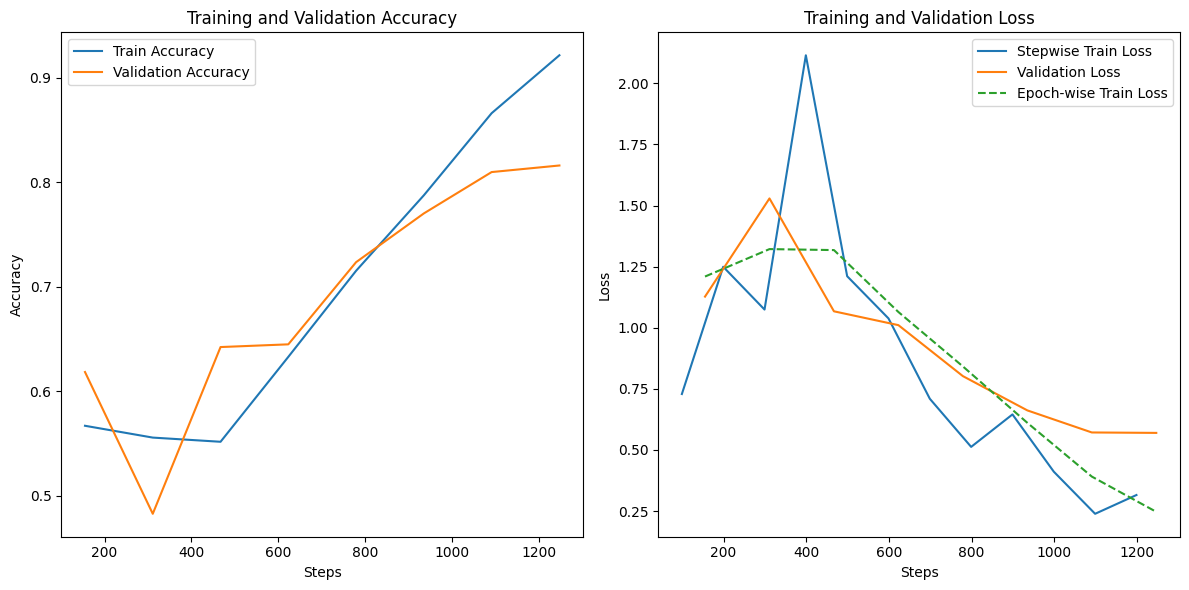

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=7-step=1248.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=7-step=1248.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (

Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.20, Val_Metric: 0.94 | Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=7-step=1248.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=7-step=1248.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.57, Val_Metric: 0.82 | Train Accuracy: 93.72
Validation Accuracy: 81.61


In [ ]:
free_memory()
seed_everything(42)
data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# trainer_config
trainer_config['max_epochs']=8
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=100

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']=0.1

#initial learning rate is 0.001 --> for initial layers it would be 0.001*0.1 = 0.0001
#and for last layers it would be 0.001
lightning_module_config['others']['learning_rate']=0.0001


# Set different learning rates for different layer groups
lightning_module_config['others']['lower_lr_layers'] = ["features.0", "features.2",
                                                        "features.5", "features.7",
                                                        "features.10", "features.12",
                                                        "features.14", "classifier.0",
                                                        "classifier.3"]
lightning_module_config['others']['higher_lr_layers'] = ["features.17", "features.19",
                                                        "features.21", "features.24",
                                                        "features.26", "features.28",
                                                        "classifier.6"]
#Dynamic Learning Rate adjustment

lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.OneCycleLR'
lightning_module_config['scheduler_params']= {'max_lr':0.001, 'epochs': 8, 'steps_per_epoch':156, 'pct_start':0.3 }
lightning_module_config['scheduler_options']= {'monitor': 'val_metric', 'interval': 'step', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='CIFAR_multiclass_VGG'
cl_config['wandb']['name']='VGG_exp5'

# Data Module
data_module_config['data_module']['batch_size']=64
data_module_config['data_module']['small_subset']=True
data_module_config['data_module']['num_samples']=10000

model, dm, lightning_module, trainer = load_components(data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
#wandb.finish()

# **Task 6 : Experimenting with a Different Pre-Trained Model**

# **Training on a pretrained model from convnext family**

In [17]:
model = models.convnext_base(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Base_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Base_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth
100%|██████████| 338M/338M [00:05<00:00, 59.6MB/s]


ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=128, out_features=512, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=512, out_features=128, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (1): Permute()
          (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (3): Linear(

In [18]:
# Function to load the model
def load_model():

  model = models.convnext_base(pretrained=True)
  for param in model.parameters():
    param.requires_grad = False


  model.classifier[2] = torch.nn.Linear(1024,10)
  for param in model.classifier[2].parameters():
    param.requires_grad = True

  return model

INFO:lightning_fabric.utilities.seed:Global seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
INFO:pytorch_lightning.utilities.rank_zero:`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..


Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | ConvNeXt           | 87.6 M
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
10.2 K    Trainable params
87.6 M    Non-trainable params
87.6 M    Total params
350.307   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 2.24, Val_Metric: 0.02 | 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 1.80, Val_Metric: 0.58 | Train_Loss: 2.16, Train_Metric: 0.29


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.05, Val_Metric: 0.75 | Train_Loss: 1.50, Train_Metric: 0.64


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 0.72, Val_Metric: 0.79 | Train_Loss: 0.99, Train_Metric: 0.73


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 0.58, Val_Metric: 0.82 | Train_Loss: 0.76, Train_Metric: 0.78


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 0.51, Val_Metric: 0.84 | Train_Loss: 0.64, Train_Metric: 0.81


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 0.47, Val_Metric: 0.85 | Train_Loss: 0.58, Train_Metric: 0.82


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 0.44, Val_Metric: 0.86 | Train_Loss: 0.54, Train_Metric: 0.83


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 0.42, Val_Metric: 0.86 | Train_Loss: 0.51, Train_Metric: 0.84


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.41, Val_Metric: 0.87 | Train_Loss: 0.49, Train_Metric: 0.85


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.40, Val_Metric: 0.87 | Train_Loss: 0.48, Train_Metric: 0.85


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.39, Val_Metric: 0.87 | Train_Loss: 0.47, Train_Metric: 0.85


Validation: 0it [00:00, ?it/s]

Epoch 12: Val_Loss: 0.39, Val_Metric: 0.87 | Train_Loss: 0.46, Train_Metric: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 13: Val_Loss: 0.38, Val_Metric: 0.87 | Train_Loss: 0.46, Train_Metric: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 14: Val_Loss: 0.39, Val_Metric: 0.87 | Train_Loss: 0.45, Train_Metric: 0.86


Validation: 0it [00:00, ?it/s]

Epoch 15: Val_Loss: 0.39, Val_Metric: 0.87 | Train_Loss: 0.45, Train_Metric: 0.86


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=15` reached.


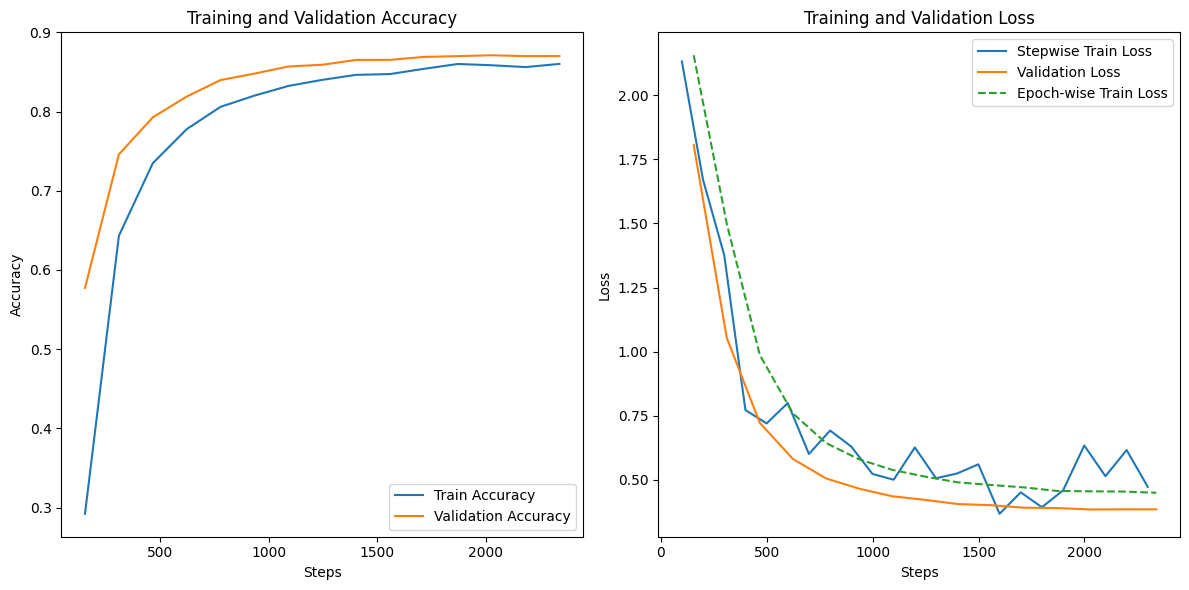

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=12-step=2028.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=12-step=2028.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument`

Validation: 0it [00:00, ?it/s]

Epoch 16: Val_Loss: 0.35, Val_Metric: 0.89 | Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=12-step=2028.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=12-step=2028.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 16: Val_Loss: 0.38, Val_Metric: 0.87 | Train Accuracy: 89.18
Validation Accuracy: 87.11


In [20]:
free_memory()
seed_everything(42)
data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# trainer_config
trainer_config['max_epochs']=15
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=100

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']=0.1
lightning_module_config['others']['learning_rate']=0.0001
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.OneCycleLR'
lightning_module_config['scheduler_params']= {'max_lr':0.001, 'epochs': 15, 'steps_per_epoch':156, 'pct_start':0.3 }
lightning_module_config['scheduler_options']= {'monitor': 'val_metric', 'interval': 'step', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='CIFAR_multiclass_VGG'
cl_config['wandb']['name']='VGG_exp5'

# Data Module
data_module_config['data_module']['batch_size']=64
data_module_config['data_module']['small_subset']=True
data_module_config['data_module']['num_samples']=10000

model, dm, lightning_module, trainer = load_components(data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
#wandb.finish()

In [21]:
ckpt_path = trainer.checkpoint_callback.best_model_path

In [22]:
test_acc = trainer.test(dataloaders=dm.test_dataloader(),
                        ckpt_path=ckpt_path,
                        verbose=True)

print(f"Test Accuracy: {test_acc[0]['test_metric']*100:0.2f}")

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=12-step=2028.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=12-step=2028.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_metric        │    0.8708999752998352     │
└───────────────────────────┴───────────────────────────┘

Test Accuracy: 87.09


# **Training on a pretrained model from resnet family**

In [23]:
model = models.resnet50(pretrained=True)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 149MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
# Function to load the model
def load_model():
    model = models.resnet50(pretrained=True)

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Modify the last layer to match the number of classes in CIFAR-10
    model.fc = torch.nn.Linear(2048, 10)
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

INFO:lightning_fabric.utilities.seed:Global seed set to 42
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | ResNet             | 23.5 M
1 | loss_fn      | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
4 | test_metric  | MulticlassAccuracy | 0     
----------------------------------------------------
20.5 K    Trainable params
23.5 M    Non-trainable params
23.5 M    Total params
94.114    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 1: Val_Loss: 2.51, Val_Metric: 0.00 | 

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 1: Val_Loss: 1.32, Val_Metric: 0.55 | Train_Loss: 1.71, Train_Metric: 0.41


Validation: 0it [00:00, ?it/s]

Epoch 2: Val_Loss: 1.02, Val_Metric: 0.64 | Train_Loss: 1.29, Train_Metric: 0.55


Validation: 0it [00:00, ?it/s]

Epoch 3: Val_Loss: 1.25, Val_Metric: 0.59 | Train_Loss: 1.34, Train_Metric: 0.56


Validation: 0it [00:00, ?it/s]

Epoch 4: Val_Loss: 1.47, Val_Metric: 0.54 | Train_Loss: 1.37, Train_Metric: 0.58


Validation: 0it [00:00, ?it/s]

Epoch 5: Val_Loss: 1.19, Val_Metric: 0.62 | Train_Loss: 1.31, Train_Metric: 0.58


Validation: 0it [00:00, ?it/s]

Epoch 6: Val_Loss: 1.00, Val_Metric: 0.65 | Train_Loss: 1.16, Train_Metric: 0.62


Validation: 0it [00:00, ?it/s]

Epoch 7: Val_Loss: 0.97, Val_Metric: 0.66 | Train_Loss: 1.04, Train_Metric: 0.65


Validation: 0it [00:00, ?it/s]

Epoch 8: Val_Loss: 0.93, Val_Metric: 0.67 | Train_Loss: 0.93, Train_Metric: 0.67


Validation: 0it [00:00, ?it/s]

Epoch 9: Val_Loss: 0.88, Val_Metric: 0.69 | Train_Loss: 0.84, Train_Metric: 0.70


Validation: 0it [00:00, ?it/s]

Epoch 10: Val_Loss: 0.84, Val_Metric: 0.71 | Train_Loss: 0.78, Train_Metric: 0.73


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


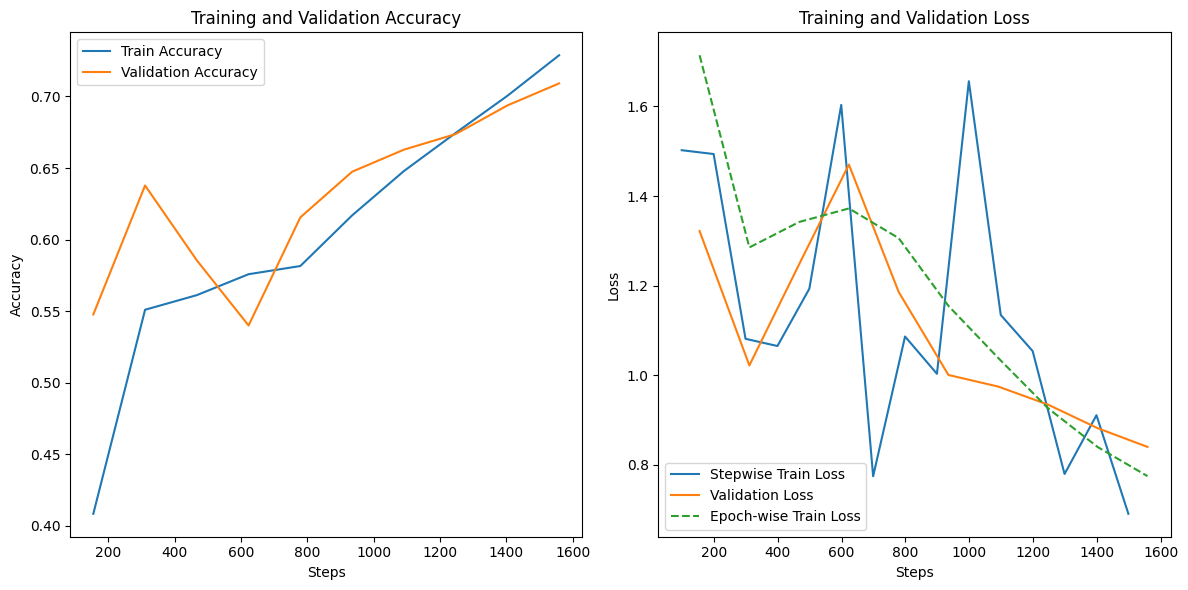

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560-v3.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560-v3.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:490: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argum

Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.73, Val_Metric: 0.75 | Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560-v3.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560-v3.ckpt


Validation: 0it [00:00, ?it/s]

Epoch 11: Val_Loss: 0.84, Val_Metric: 0.71 | Train Accuracy: 74.70
Validation Accuracy: 70.91


In [26]:
free_memory()
seed_everything(42)
data_module_config, lightning_module_config, cl_config, trainer_config = load_all_configs()

# trainer_config
trainer_config['max_epochs']=10
trainer_config['gradient_clip_val']=2
trainer_config['log_every_n_steps']=100

# lightning module config
lightning_module_config['others']['optimizer_params']['weight_decay']=0.1
lightning_module_config['others']['learning_rate']=0.001
lightning_module_config['scheduler_cls']='torch.optim.lr_scheduler.OneCycleLR'
lightning_module_config['scheduler_params']= {'max_lr':0.01, 'epochs': 10, 'steps_per_epoch':156, 'pct_start':0.3 }
lightning_module_config['scheduler_options']= {'monitor': 'val_metric', 'interval': 'step', 'frequency': 1}

# logging
cl_config['lr_monitor']['logging_interval']='epoch'
cl_config['wandb']['project']='CIFAR_multiclass_VGG'
cl_config['wandb']['name']='VGG_exp5'

# Data Module
data_module_config['data_module']['batch_size']=64
data_module_config['data_module']['small_subset']=True
data_module_config['data_module']['num_samples']=10000

model, dm, lightning_module, trainer = load_components(data_module_config,
                                                       lightning_module_config, data_folder, trainer_config,
                                                        cl_config, batch_size=data_module_config['data_module']['batch_size'],
                                                        logging=True, checkpointing=True, early_stopping=False)
dm.setup()
trainer.fit(lightning_module, dm)
file = f"{trainer.logger.log_dir}/metrics.csv"
plot_losses_acc(file)
ckpt_path = trainer.checkpoint_callback.best_model_path
train_acc = trainer.validate(dataloaders=dm.train_dataloader(), ckpt_path=ckpt_path, verbose=False)
valid_acc = trainer.validate(dataloaders=dm.val_dataloader(), ckpt_path=ckpt_path, verbose=False)
print(f"Train Accuracy: {train_acc[0]['val_metric']*100:0.2f}")
print(f"Validation Accuracy: {valid_acc[0]['val_metric']*100:0.2f}")
#wandb.finish()

In [27]:
ckpt_path = trainer.checkpoint_callback.best_model_path

In [28]:
test_acc = trainer.test(dataloaders=dm.test_dataloader(),
                        ckpt_path=ckpt_path,
                        verbose=True)

print(f"Test Accuracy: {test_acc[0]['test_metric']*100:0.2f}")

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560-v3.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from the checkpoint at /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Models/logs/epoch=9-step=1560-v3.ckpt
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test_metric        │    0.6987000107765198     │
└───────────────────────────┴───────────────────────────┘

Test Accuracy: 69.87


# **Conclusion:**

- **Data Preparation and Augmentation for CIFAR-10:** Used random horizontal flip Data Augmentation technique for the training set. By introducing the occasional horizontal flip of images during training, the model gains increased variability, making it more adaptable to diverse orientations of objects in real-world scenarios. This approach acts as a regularizer, reducing overfitting and enhancing the model's ability to generalize to new, unseen data. It also aids in efficiently expanding the training dataset by generating augmented samples on-the-fly, contributing to better overall model performance and robustness.
- **Size of the training data:** ***I used only 10,000 samples*** from the training set(consists total of 40,000 images) during the training process. Despite purchasing 100 GPU compute units twice, they proved inadequate for conducting experiments on the full set of 40,000 training samples. Consequently, I had to train the model on the smaller subset. This limitation is the primary reason I was unable to achieve 90% accuracy in Tasks 2, 3, 4, 5, and 6
- Accuracies achieved on the **test set (10,000 images)** across all the tasks:
- Task2: Test Accuracy: 72.68%
- Task3: Test Accuracy: 81.78%
- Task4: Test Accuracy: 81.68%
- Task6 (Convnext): Test Accuracy: 87.09%
- Task7 (Resnet): Test Accuracy: 69.87%





In [ ]:
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-plain-generic

In [32]:
!jupyter nbconvert --to pdf /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Pooja_Akkaladevi_HW7.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Pooja_HP_Singh_Projects/DL/HW7_CIFAR_VGG/Pooja_Akkaladevi_HW7.ipynb to pdf
[NbConvertApp] ERROR | Notebook JSON is invalid: Additional properties are not allowed ('metadata' was unexpected)

Failed validating 'additionalProperties' in stream:

On instance['cells'][54]['outputs'][0]:
{'metadata': {'tags': None},
 'name': 'stderr',
 'output_type': 'stream',
 'text': 'INFO:lightning_fabric.utilities.seed:Global seed set to 42\n'
         'INFO:...'}
[NbConvertApp] Support files will be in Pooja_Akkaladevi_HW7_files/
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW7_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW7_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW7_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW7_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW7_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW7_files
[NbConvertApp] Making directory ./Pooja_Akkaladevi_HW7_fi